In [1]:
#!pip install yfinance
#!pip install

In [2]:
#!pip install yahooquery
#!pip install ta

In [4]:
import yfinance as yf
import pandas as pd
from yahooquery import Screener
import ta
from typing import Callable, List, Generator

In [61]:
class Asset(yf.Ticker):
    _price_field = 'Close'
    def __init__(self, ticker: str):
        super().__init__(ticker)

    def get_moving_averages(self, start_date: str, end_date: str, moving_average_days_list: List[int]) -> Generator[pd.Series, None, None]:
        df = self.history(start=start_date, end=end_date)[self._price_field]
        for d in moving_average_days_list:
            ma = df.rolling(window=d).mean()
            ma.name = f'SMA_{d}'
            yield ma

    def get_golden_crosses(self, start_date: str, end_date: str) -> pd.Series:
        moving_averages = self.get_moving_averages(start_date, end_date, moving_average_days_list=[50, 200])
        sma50, sma200 = list(moving_averages)
        return (sma50 > sma200) & (sma50.shift(1) < sma200.shift(1))

    def get_rsi_signal(self, start_date, end_date):
        s = self.history(start=start_date, end=end_date)[self._price_field]
        rsi = ta.momentum.RSIIndicator(s).rsi()
        return  rsi.apply(lambda x: -1 if x > 70 else 1 if x < 30 else 0)


In [62]:
class SingleStock(Asset):
    _fundamental_indicators = ['forwardPE','trailingEps', 'dividendYield', 'priceToBook', 'returnOnEquity']
        
    def get_last_fundamental_indicators(self):
        return {k:v for k,v in self.info.items() if k in self._fundamental_indicators}

    def get_last_fundamental_buy_signal(self):
        indicators = self.get_last_fundamental_indicators()
        pe_ratio = indicators.get('forwardPE', None)
        eps = indicators.get('trailingEps', None)
        dividend_yield = indicators.get('dividendYield', None)
        pb_ratio = indicators.get('priceToBook', None)
        roe = indicators.get('returnOnEquity', None)
        
        # Define your criteria for a good buy
        cond_pe_ratio = pe_ratio and pe_ratio < 20
        cond_eps = eps and eps > 0 
        cond_dvd_yield = dividend_yield and dividend_yield > 0.02
        cond_pb_ratio = pb_ratio and pb_ratio < 3
        cond_roe = roe and roe > 0.15

        if (cond_pe_ratio and cond_eps and cond_dvd_yield and cond_pb_ratio and cond_roe):
            return 1
        return 0

In [63]:
class EquityBasket:
    def __init__(self, stock_list):
        self.stock_list = stock_list
    
    def get_stock_to_buy(self):
        report_dict = {stock: SingleStock(stock).get_last_fundamental_buy_signal() for stock in self.stock_list}
        return [k for k,v in report_dict.items() if v==1]

In [64]:
ftse_mib_tickers = [
    "A2A.MI", "AMP.MI", "G.MI", "ATL.MI", "AZM.MI", "BPE.MI", "BZU.MI", 
    "DIA.MI", "ENEL.MI", "ENI.MI", "EXO.MI", "RACE.MI", "FBK.MI", "HER.MI", "ISP.MI", 
    "IG.MI", "JUVE.MI", "LDO.MI", "MB.MI", "MONC.MI", "NEXI.MI", "PIRC.MI", "PST.MI", 
    "PRY.MI", "REC.MI", "SPM.MI", "SRG.MI", "STM.MI", "TIT.MI", "TEN.MI", "TRN.MI", 
    "UCG.MI", "UNI.MI", "BMED.MI", "BAMI.MI", "INW.MI", "BMED.MI", "BPE.MI", "CPR.MI"
]

In [65]:
EquityBasket(ftse_mib_tickers).get_stock_to_buy()

['A2A.MI',
 'AZM.MI',
 'BPE.MI',
 'IG.MI',
 'PST.MI',
 'TEN.MI',
 'TRN.MI',
 'UCG.MI',
 'BMED.MI']

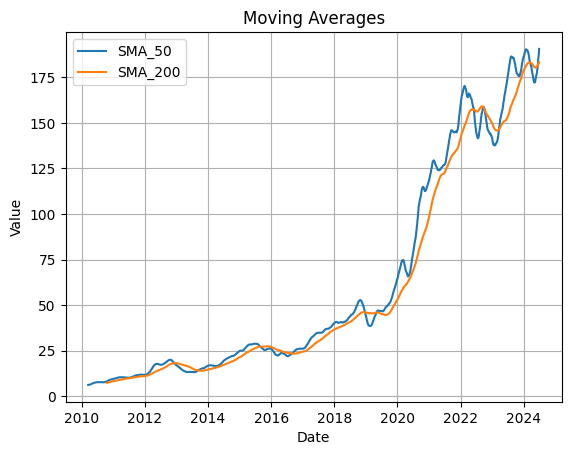

In [66]:
import matplotlib.pyplot as plt
apple = SingleStock('AAPL')

plt.figure()

# Iterate through the generator and plot each series
for s in apple.get_moving_averages(start_date='2010-01-01', end_date='2024-06-30', moving_average_days_list=[50, 200]):
    plt.plot(s, label=s.name)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Moving Averages')
plt.legend()
plt.grid()
plt.show()


## Crypto

In [67]:
class CryptoBasket:
    def __init__(self, crypto_list):
        self.crypto_list = crypto_list

    def get_golden_crosses(self, start_date, end_date):
        return {crypto: Asset(crypto).get_golden_crosses(start_date, end_date) for crypto in self.crypto_list}
        

In [68]:
# Initialize the Screener
s = Screener()

# Get the list of the first 20 cryptocurrencies
data = s.get_screeners('all_cryptocurrencies_us', count=20)

# Extract the symbols
crypto_symbols = [item['symbol'] for item in data['all_cryptocurrencies_us']['quotes']]


In [69]:
crypto_basket = CryptoBasket(crypto_symbols)

In [76]:
for k,v in crypto_basket.get_golden_crosses(start_date='2024-06-01', end_date='2024-06-30').items():
    print(k,v[v].index)

BTC-USD DatetimeIndex([], dtype='datetime64[ns, UTC]', name='Date', freq=None)
ETH-USD DatetimeIndex([], dtype='datetime64[ns, UTC]', name='Date', freq=None)
USDT-USD DatetimeIndex([], dtype='datetime64[ns, UTC]', name='Date', freq=None)
BNB-USD DatetimeIndex([], dtype='datetime64[ns, UTC]', name='Date', freq=None)
SOL-USD DatetimeIndex([], dtype='datetime64[ns, UTC]', name='Date', freq=None)
XRP-USD DatetimeIndex([], dtype='datetime64[ns, UTC]', name='Date', freq=None)
USDC-USD DatetimeIndex([], dtype='datetime64[ns, UTC]', name='Date', freq=None)
STETH-USD DatetimeIndex([], dtype='datetime64[ns, UTC]', name='Date', freq=None)
DOGE-USD DatetimeIndex([], dtype='datetime64[ns, UTC]', name='Date', freq=None)
TON11419-USD DatetimeIndex([], dtype='datetime64[ns, UTC]', name='Date', freq=None)
ADA-USD DatetimeIndex([], dtype='datetime64[ns, UTC]', name='Date', freq=None)
WSTETH-USD DatetimeIndex([], dtype='datetime64[ns, UTC]', name='Date', freq=None)
WTRX-USD DatetimeIndex([], dtype='datet

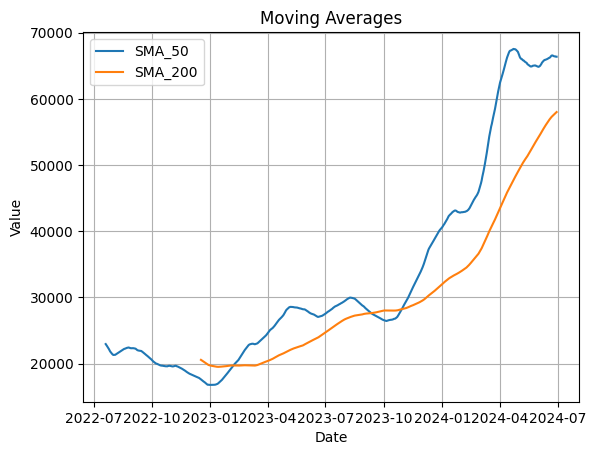

In [78]:
import matplotlib.pyplot as plt
apple = SingleStock('BTC-USD')

plt.figure()

# Iterate through the generator and plot each series
for s in apple.get_moving_averages(start_date='2022-06-01', end_date='2024-06-30', moving_average_days_list=[50, 200]):
    plt.plot(s, label=s.name)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Moving Averages')
plt.legend()
plt.grid()
plt.show()